In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras.preprocessing import image

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data

In [ ]:
train_dir = 'drive/MyDrive/Capstone Project/dataset/dataset v2/train'
valid_dir = 'drive/MyDrive/Capstone Project/dataset/dataset v2/val'
test_dir = 'drive/MyDrive/Capstone Project/dataset/dataset v2/test'

# train_dir = 'drive/MyDrive/capstone dataset/dataset/dataset/dataset/train'
# valid_dir = 'drive/MyDrive/capstone dataset/dataset/dataset/dataset/valid'
# test_dir = 'drive/MyDrive/capstone dataset/dataset/dataset/dataset/test'

ImageGen

In [ ]:
BATCH_SIZE = 64

In [ ]:
# Datagen
train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # shear_range=0.2,
    # zoom_range=0.2,
    fill_mode='nearest',
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
    # horizontal_flip=True,
    # validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen =  ImageDataGenerator(rescale=1./255)

# Flow training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

# Flow validation data generator
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(28, 28),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

# Flow test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)


Found 349 images belonging to 5 classes.
Found 98 images belonging to 5 classes.
Found 49 images belonging to 5 classes.


Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), input_shape=(28, 28, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),

    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(512, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 13, 13, 16)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 2704)              0         
                                                                 
 dropout_5 (Dropout)         (None, 2704)              0         
                                                                 
 dense_10 (Dense)            (None, 64)                173120    
                                                                 
 dense_11 (Dense)            (None, 5)                 325       
                                                      

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

#Callbacks

In [ ]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy'] >= 0.83:
            self.model.stop_training = True
early_stop = EarlyStoppingCallback()

#train Model

In [ ]:
history = model.fit(train_generator,
                    epochs=150,
                    # steps_per_epoch=50,
                    validation_data=validation_generator
                    #validation_steps=50,
                    # callbacks=[early_stop]
)

Epoch 1/150
6/6 [==============================] - 3s 221ms/step - loss: 1.6854 - accuracy: 0.1920 - val_loss: 1.5449 - val_accuracy: 0.3776
Epoch 2/150
6/6 [==============================] - 1s 252ms/step - loss: 1.5558 - accuracy: 0.3381 - val_loss: 1.5034 - val_accuracy: 0.3571
Epoch 3/150
6/6 [==============================] - 1s 251ms/step - loss: 1.4964 - accuracy: 0.3696 - val_loss: 1.4194 - val_accuracy: 0.4286
Epoch 4/150
6/6 [==============================] - 2s 363ms/step - loss: 1.4126 - accuracy: 0.4040 - val_loss: 1.3492 - val_accuracy: 0.4490
Epoch 5/150
6/6 [==============================] - 2s 282ms/step - loss: 1.3479 - accuracy: 0.4556 - val_loss: 1.3218 - val_accuracy: 0.4592
Epoch 6/150
6/6 [==============================] - 2s 305ms/step - loss: 1.2930 - accuracy: 0.4527 - val_loss: 1.3317 - val_accuracy: 0.3980
Epoch 7/150
6/6 [==============================] - 1s 235ms/step - loss: 1.2533 - accuracy: 0.4756 - val_loss: 1.2253 - val_accuracy: 0.4490
Epoch 8/150
6

#make test_data and test_label

In [ ]:
import os
import cv2
import numpy as np
from keras.preprocessing import image
from keras.utils import to_categorical

# Set the path to your test data directory
test_data_directory = test_dir

# Get the list of class names (assuming subdirectories in test_data_directory are class names)
class_names = sorted(os.listdir(test_data_directory))

# Initialize empty lists to store test data and labels
test_data = []
test_labels = []


# Load and preprocess test data
for class_index, class_name in enumerate(class_names):
    class_path = os.path.join(test_data_directory, class_name)

    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)

        # Load and preprocess the image
        img = image.load_img(file_path, target_size=(28, 28))  # Adjust target_size based on your model's input size
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.imagenet_utils.preprocess_input(img_array)  # Assuming you have a preprocessing function, e.g., from keras.applications import preprocess_input

        # Append the preprocessed image to test_data
        test_data.append(img_array)

        # Append the class index (label) to test_labels
        test_labels.append(class_index)

# Convert lists to numpy arrays
test_data = np.vstack(test_data)
test_labels = np.array(test_labels)

# Convert labels to one-hot encoding (if needed)
test_labels_one_hot = to_categorical(test_labels, num_classes=len(class_names))

# Shuffle the test data and labels (if needed)
indices = np.random.permutation(len(test_data))
test_data = test_data[indices]
test_labels = test_labels[indices]
test_labels_one_hot = test_labels_one_hot[indices]


In [ ]:
# from keras.preprocessing.image import ImageDataGenerator

# # Define the path to your test data directory
# test_data_dir = test_dir

# # Set the target size based on your model's input size
# target_size = (28, 28)

# # Create an ImageDataGenerator for test data
# test_datagen = ImageDataGenerator(rescale=1./255)  # You can add other preprocessing steps if needed

# # Create a test generator
# test_generator = test_datagen.flow_from_directory(
#     test_data_dir,
#     target_size=target_size,
#     batch_size=32,  # Adjust batch size based on your preference
#     class_mode='categorical',  # Set to 'binary' for binary classification
#     shuffle=False  # Keep the order of predictions consistent for evaluation
# )

# # Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


1/1 [==============================] - 0s 155ms/step - loss: 0.7901 - accuracy: 0.7551
Test Loss: 0.7901325821876526
Test Accuracy: 0.7551020383834839


#Using Confusion Matrix to see the accuracy

1/1 [==============================] - 0s 128ms/step


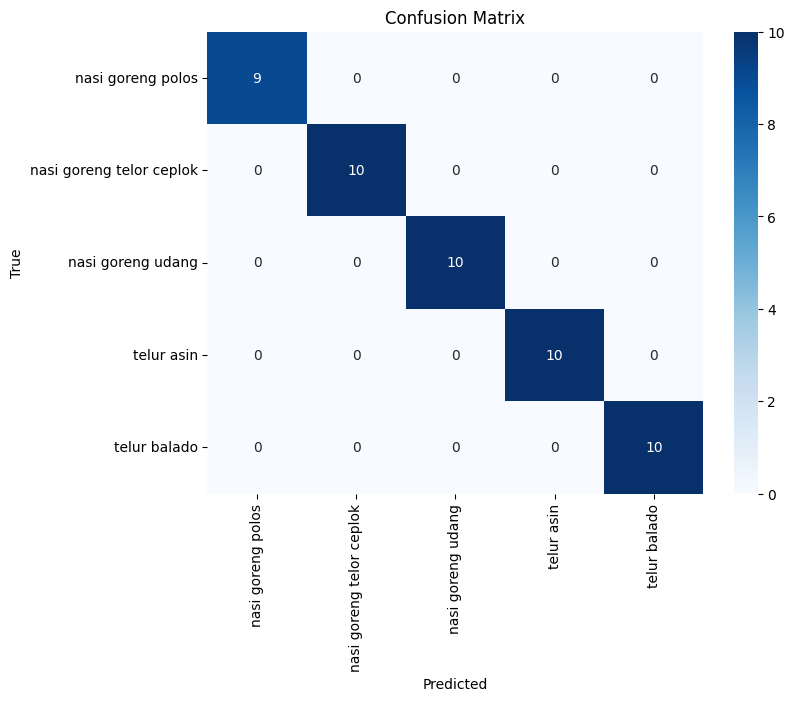


Classification Report:
                          precision    recall  f1-score   support

       nasi goreng polos       1.00      1.00      1.00         9
nasi goreng telor ceplok       1.00      1.00      1.00        10
       nasi goreng udang       1.00      1.00      1.00        10
              telur asin       1.00      1.00      1.00        10
            telur balado       1.00      1.00      1.00        10

                accuracy                           1.00        49
               macro avg       1.00      1.00      1.00        49
            weighted avg       1.00      1.00      1.00        49



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a model that is already trained
# Make predictions on the test data
predictions = model.predict(test_generator)

# Convert predictions to class labels
predicted_labels = test_generator.classes

# Convert true labels to class labels (assuming they are integers)
true_labels = test_labels

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))


Confusion another

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Load the model

# Get the labels and predictions for the validation data
# validation_labels = validation_generator.classes
# validation_predictions = model.predict(validation_generator)

test_labels = test_generator.classes
test_predictions = model.predict(test_generator)

# Create the confusion matrix
#confusion_matrix = confusion_matrix(validation_labels, validation_predictions.argmax(axis=1))
confusion_matrix = confusion_matrix(test_labels, test_predictions.argmax(axis=1))


# Print the confusion matrix
print(confusion_matrix)

1/1 [==============================] - 0s 128ms/step
[[ 5  1  3  0  0]
 [ 2  5  2  1  0]
 [ 0  0 10  0  0]
 [ 0  2  0  8  0]
 [ 0  0  1  0  9]]


Model.predict with only 1 image


Save Model

In [ ]:
model.save('model_capstone.keras')

Evaluate model

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Load the model
# model = tf.keras.models.load_model('model_capstone.h5')

# Get the labels and predictions for the test data
test_labels = test_generator.classes
test_predictions = model.predict(test_generator)

# Evaluate the model
accuracy = accuracy_score(test_labels, test_predictions.argmax(axis=1))
precision = precision_score(test_labels, test_predictions.argmax(axis=1), average='macro')
recall = recall_score(test_labels, test_predictions.argmax(axis=1), average='macro')
f1 = f1_score(test_labels, test_predictions.argmax(axis=1), average='macro')
# roc_auc = roc_auc_score(test_labels, test_predictions, multi_class='ovo')

# Print the results
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)
# print('ROC AUC:', roc_auc)

1/1 [==============================] - 0s 132ms/step
Accuracy: 0.7551020408163265
Precision: 0.7706349206349207
Recall: 0.7511111111111111
F1 score: 0.7478520017993702


Make class text

In [ ]:
class_names = list(train_generator.class_indices.keys())
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

Predict with one image

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files

# Load the labels associated with the model
with open('labels.txt', 'r') as file:
    class_labels = [line.strip() for line in file]

# Upload an image file
uploaded = files.upload()

# Get the uploaded image path
img_path = list(uploaded.keys())[0]

# Load and preprocess the image
img = image.load_img(img_path, target_size=(28, 28))  # Adjust target size if needed
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize if needed

# Make predictions
predictions = model.predict(img_array)

# Decode and output the predicted label as a string
predicted_label_index = np.argmax(predictions[0])
predicted_label = class_labels[predicted_label_index]
print("Predicted Label:", predicted_label)


Convert to Tflite

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the Keras model
model = load_model('Model_capstone.keras')

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('converted_model.tflite', 'wb') as f:
    f.write(tflite_model)
